# **# Experiment 5.3: Sequence Text Classification using LSTM**

 Objective:
To classify text sequences using LSTM-based models (e.g., sentiment or spam detection).

Name: Om Borle

PRN: 202201040035

Div: A1

Group Members: Vaibhav Jadhav, Md Yaseen Alam, Vidya Bingi

Dataset Link: https://github.com/justmarkham/pycon-2016-tutorial/blob/master/
data/sms.tsv
same dataset on kaggle: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

Github Link: https://github.com/omborle/DL-Assignment-5

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


193/193 ━━━━━━━━━━━━━━━━━━━━ 54s 251ms/step - accuracy: 0.7818 - loss: 0.4396 - val_accuracy: 0.8348 - val_loss: 0.3956
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 69s 187ms/step - accuracy: 0.9586 - loss: 0.1230 - val_accuracy: 0.8653 - val_loss: 0.3280
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 35s 182ms/step - accuracy: 0.9771 - loss: 0.0784 - val_accuracy: 0.7979 - val_loss: 0.5185
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.9844 - loss: 0.0549 - val_accuracy: 0.8659 - val_loss: 0.4076
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 45s 205ms/step - accuracy: 0.9896 - loss: 0.0394 - val_accuracy: 0.8575 - val_loss: 0.4375
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.9937 - loss: 0.0302 - val_accuracy: 0.8601 - val_loss: 0.5044
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.9941 - loss: 0.0198 - val_accuracy: 0.8821 - val_loss: 0.4918
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.9941 - loss: 0.0180 - val

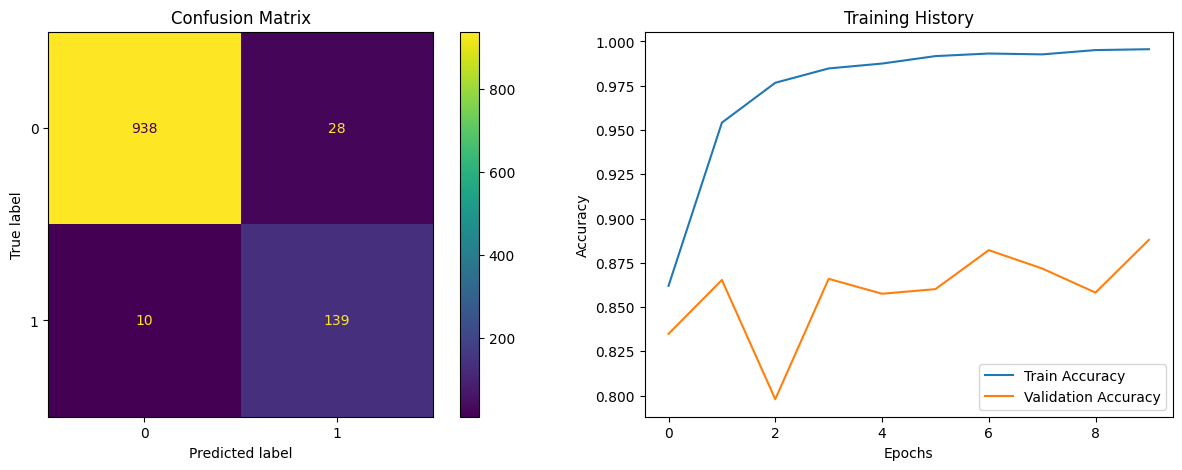

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import re

# Load dataset
url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'text'])

# Text preprocessing
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().strip()
    return " ".join(text.split())
df['text'] = df['text'].apply(clean_text)

# Label encoding
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label_enc'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_enc']
)

# Sequence processing
max_words = 5000
max_len = 150
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Handle class imbalance
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_pad, y_train)

# LSTM Model architecture
model = tf.keras.Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Model training
history = model.fit(
    X_train_res, y_train_res,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluation
print("\nModel Evaluation:")
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax[0])
ax[0].set_title('Confusion Matrix')

# Training history
ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training History')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()
